<center>
<h1>
Analyzing the Sentiment of Online Substance Abuse Support Groups During the
COVID-19 Pandemic via Natural Language Processing
</h1>   
<h5> 
<a href="https://www.google.com">Read the paper</a>
</h5>
</center>

In [1]:
!pip3 install -r requirements.txt

/home/zeyad/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/zeyad/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [1]:
# python wrapper for the official reddit api
import praw 

# python wrapper for the pushshift api
from psaw import PushshiftAPI 

import json

# the data retrieved from the PushShift API is stored in a pandas dataframe
import pandas as pd
import numpy as np

# the datetime object allows for easy chronological organization of the dataframe 
from datetime import datetime
from calendar import monthrange
import time

import random
import sys
import os
import statistics
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from collections import Counter
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/zeyad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/zeyad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The "score" is the total number of upvotes minus he total number of downvotes that Reddit displays publicly. 
Because PushShift scrapes posts only once (shortly after they are posted), the collected score is only accurate at the time they were scraped.
This is why it is necessary to use PSAW in conjuction with PRAW (the official Reddit API) to get the current score.

In [2]:
# client_secrets.json file must be created and edited to contain credentials
# ex_client_secrets.json contains the example credentials format
f = open('client_secrets.json') 
 
client_secrets = json.load(f)

r = praw.Reddit(client_id=client_secrets["client_id"],
    client_secret=client_secrets["client_secret"],
    username=client_secrets["username"],
    password=client_secrets["password"],
    user_agent=client_secrets["user_agent"]
)

api = PushshiftAPI(r)

In [3]:
#helper functions

def save_posts_by_month(subreddit, year, month, limit=100000):
    ''' 
    scrapes posts from the specified subreddit and saves to CSV file
    the year, month parameters specify the particular month to consider
    the min_score parameter specifies the minimum score that a post must have
    '''
    num_days = monthrange(year, month)[1]
    after=int(datetime(year, month, 1).timestamp())
    before=int(datetime(year, month, num_days).timestamp()) 
    print(f"Scraping posts from /r/{subreddit} [{year}, {month}]...")
    gen = api.search_submissions(after=after, before=before, subreddit=subreddit, limit=limit)
    post_list = []
    for e in gen:
        submission = r.submission(e)
        post_list.append({"Date": datetime.fromtimestamp(submission.created_utc), "URL": submission.url, "Title": submission.title, "Body": submission.selftext, "Score": submission.score})
        
    df = pd.DataFrame(post_list)
    df.to_csv(f"data/{subreddit}/{subreddit}_{year}-{month}.csv", index = False, header = True)
    
def iter_months(start_year, start_month, end_year, end_month):
    ''' 
    yields all of the months from start date to end date
    format is year-month
    '''
        
    while (start_year == end_year and start_month <= end_month) or (start_year < end_year):
        if start_month < 12:
            yield {"year":start_year, "month":start_month}
            start_month += 1
        else:
            yield {"year":start_year, "month":start_month}
            start_year += 1
            start_month = 1

In [4]:
def scrape_posts(subreddits, start_year, start_month, end_year, end_month):
    print(f"{len(subreddits)} subreddits selected")

    datadir = 'data'
    try:
        os.mkdir('data')
        print(f"Directory '{datadir}' was created") 
    except FileExistsError:
        print(f"Directory '{datadir}' already exists")
        
    for subreddit in subreddits:
        datadir = f"data/{subreddit}"
        try:
            os.mkdir(datadir)
            print(f"Directory '{datadir}' was created") 
        except FileExistsError:
            print(f"Directory '{datadir}' already exists")
            continue
            
        for date in iter_months(start_year, start_month, end_year, end_month):
            save_posts_by_month(subreddit, date["year"], date["month"])
       
    
subreddits = ["addiction", "alcoholism", "benzorecovery", "leaves", "OpiatesRecovery", "quittingkratom", 
              "QuittingPhenibut", "redditorsinrecovery",  "StopDrinking", "StopSmoking", "StopSpeeding"]  
start_year = 2019
start_month = 10
end_year = 2022
end_month = 2
scrape_posts(subreddits, start_year, start_month, end_year, end_month)


11 subreddits selected
Directory 'data' already exists
Directory 'data/addiction' already exists
Directory 'data/alcoholism' already exists
Directory 'data/benzorecovery' already exists
Directory 'data/leaves' already exists
Directory 'data/OpiatesRecovery' already exists
Directory 'data/quittingkratom' already exists
Directory 'data/QuittingPhenibut' already exists
Directory 'data/redditorsinrecovery' already exists
Directory 'data/StopDrinking' already exists
Directory 'data/StopSmoking' already exists
Directory 'data/StopSpeeding' already exists


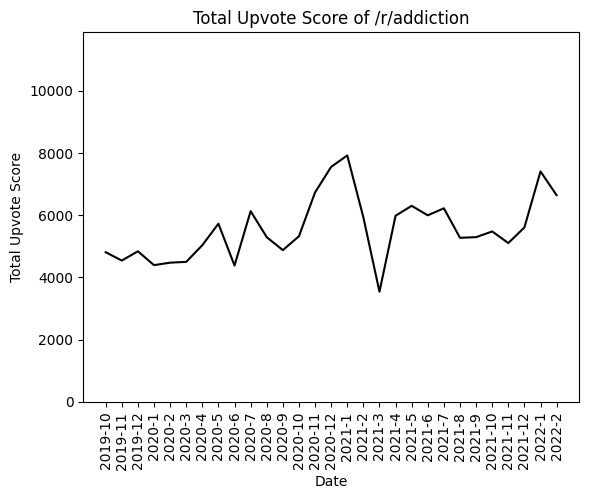

In [5]:
plt.style.use('default')

#only plot one subreddit since this is for demonstration
for subreddit in ["addiction"]: 
    dates = list()
    scores_stat = list()
    for date in iter_months(start_year, start_month, end_year, end_month): 
        score_list = list()
        df = pd.read_csv(f'data/{subreddit}/{subreddit}_{date["year"]}-{date["month"]}.csv')
        for index, row in df.iterrows():
            score_list.append(row["Score"])
        scores_stat.append(sum(score_list))
        dates.append(f'{date["year"]}-{date["month"]}')             
    x = dates
    y = scores_stat
    plt.xticks(rotation=90)
    plt.xlabel('Date')
    plt.ylabel('Total Upvote Score')
    plt.title(f'Total Upvote Score of /r/{subreddit}')
    plt.ylim(ymin=0, ymax = max(y)*1.5)
    plt.plot(x, y, color='black');
    plt.show()

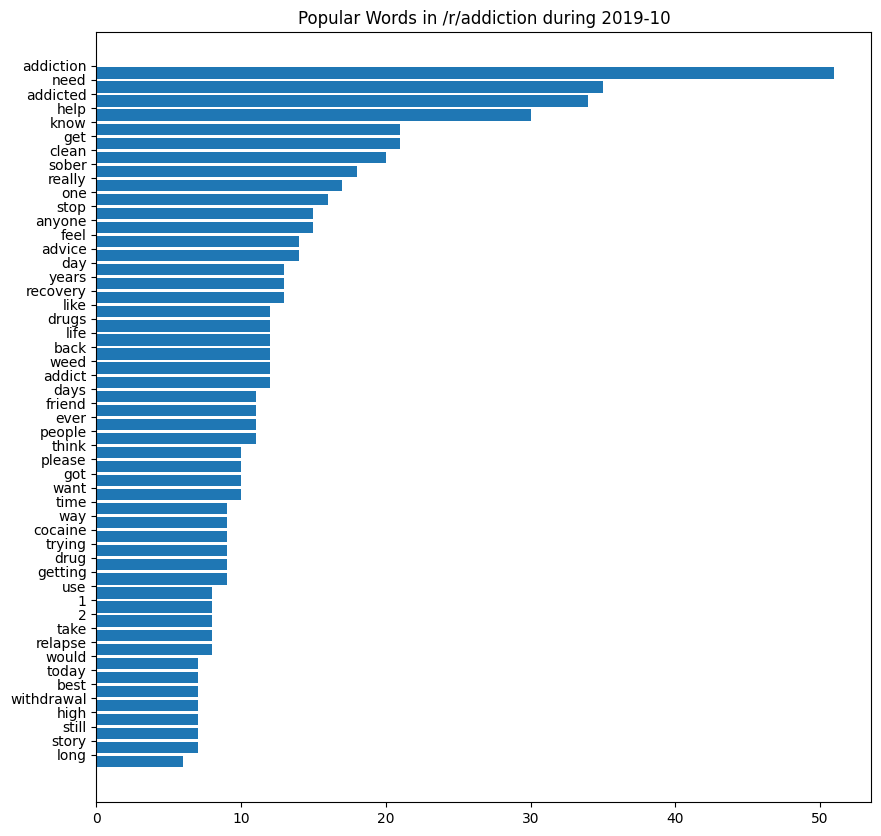

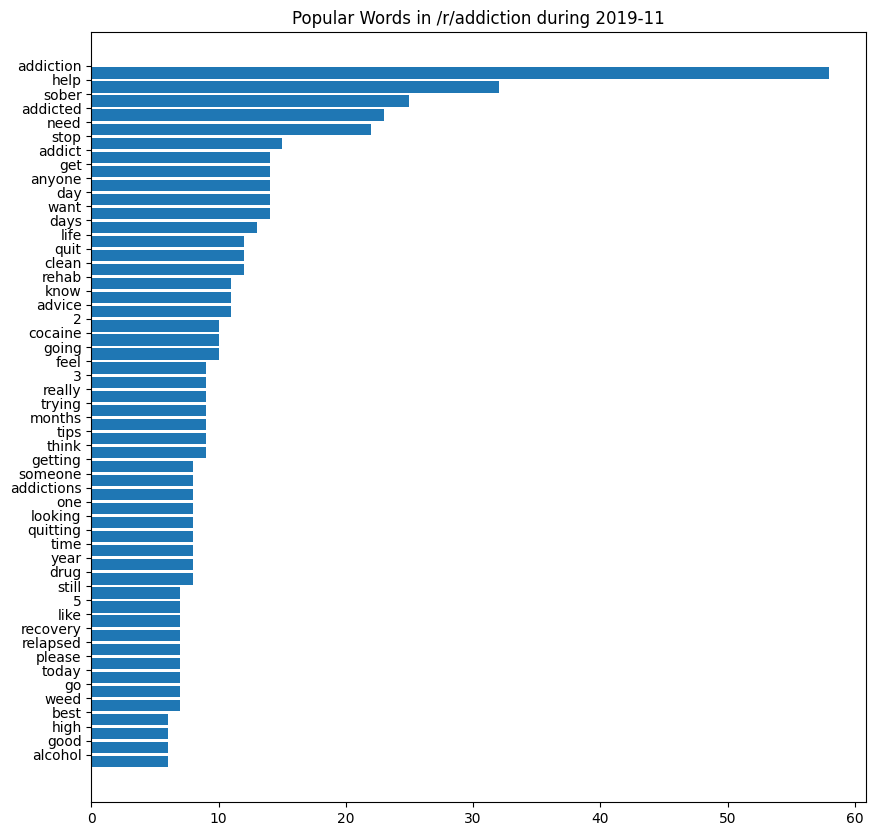

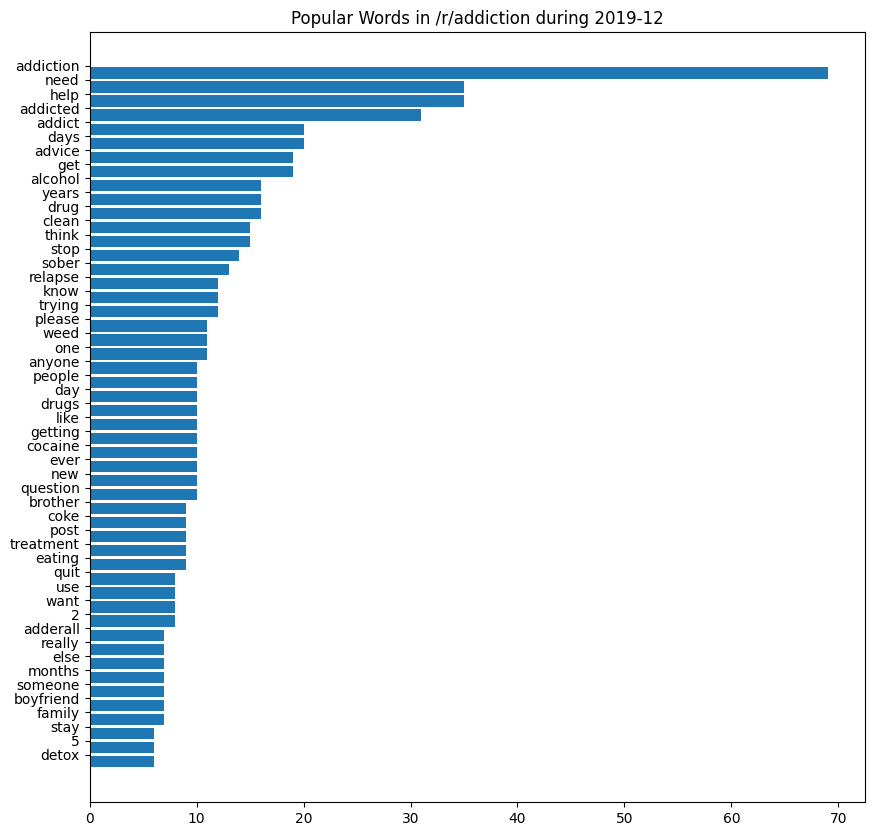

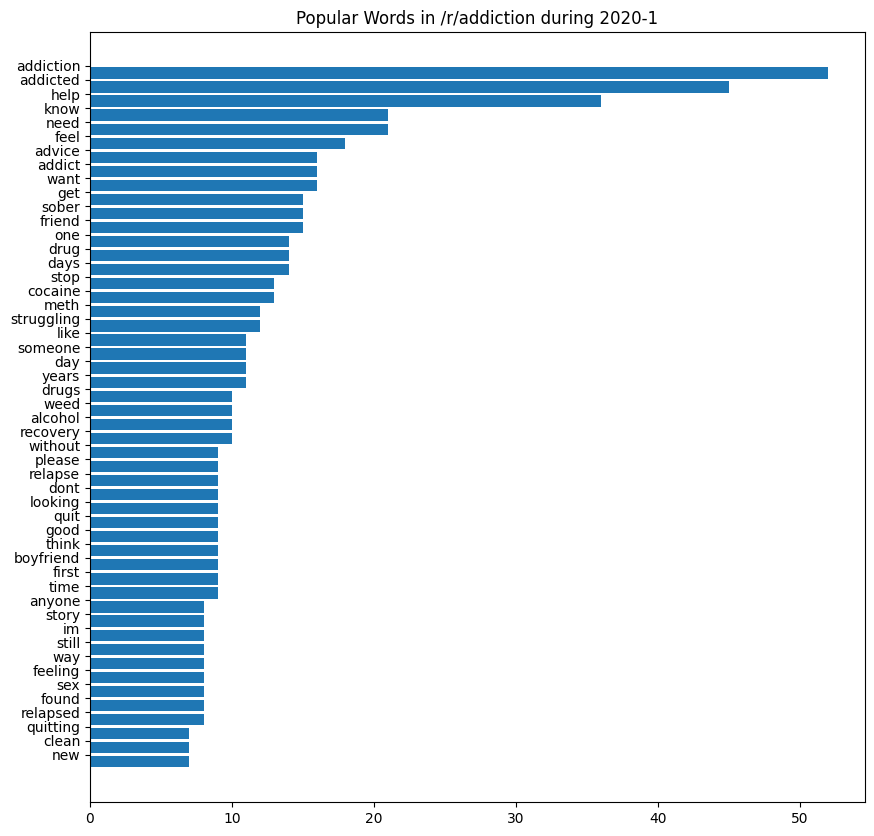

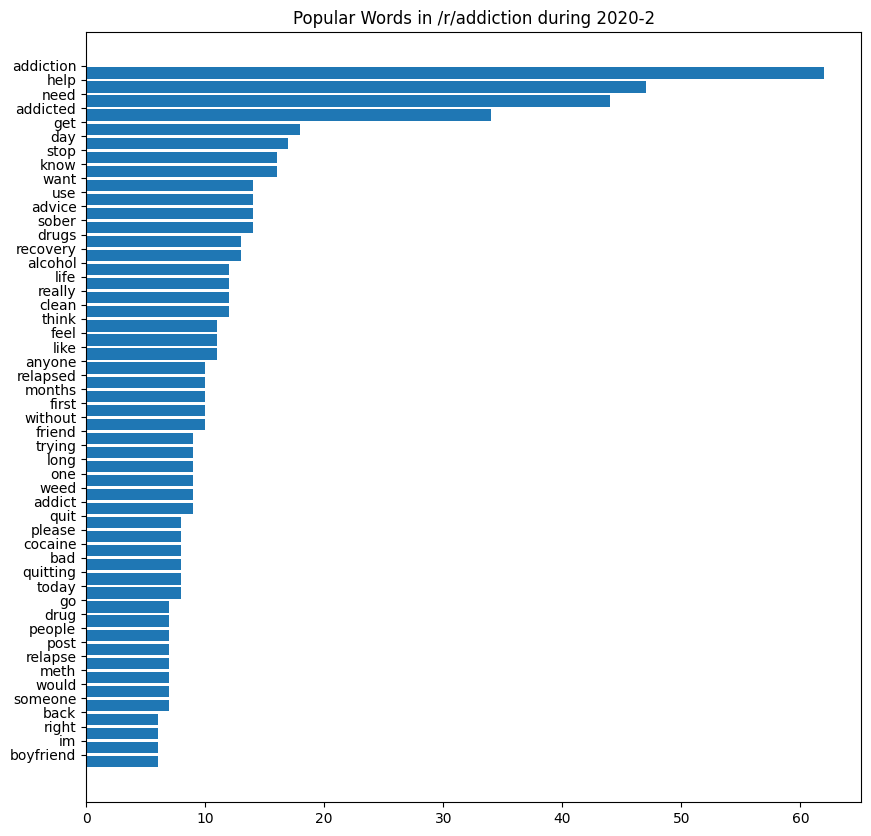

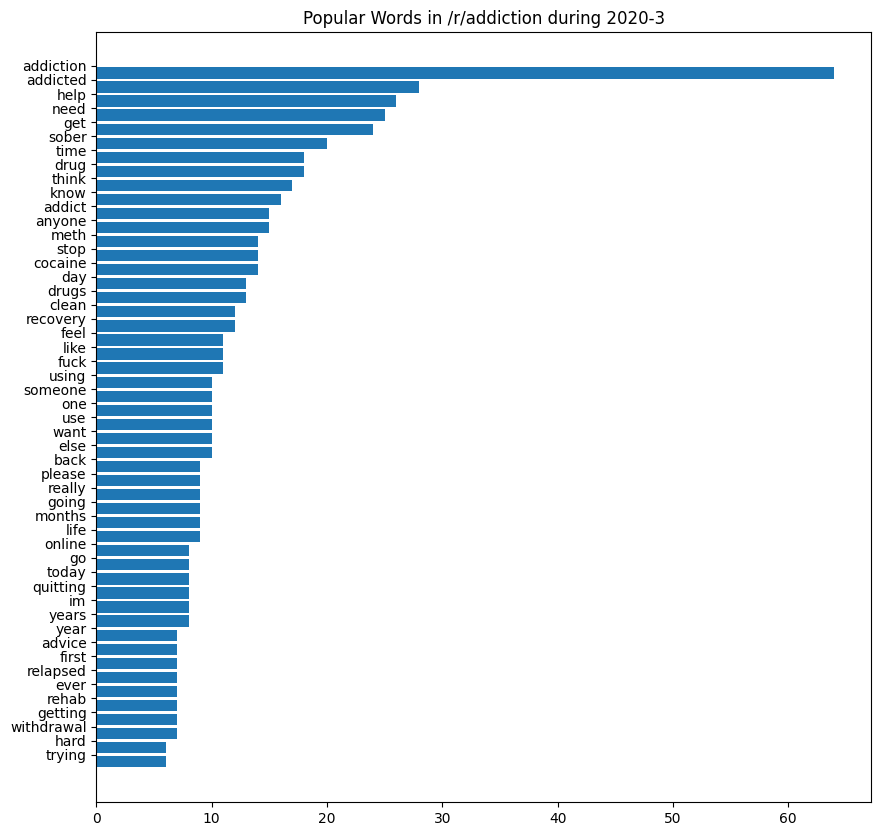

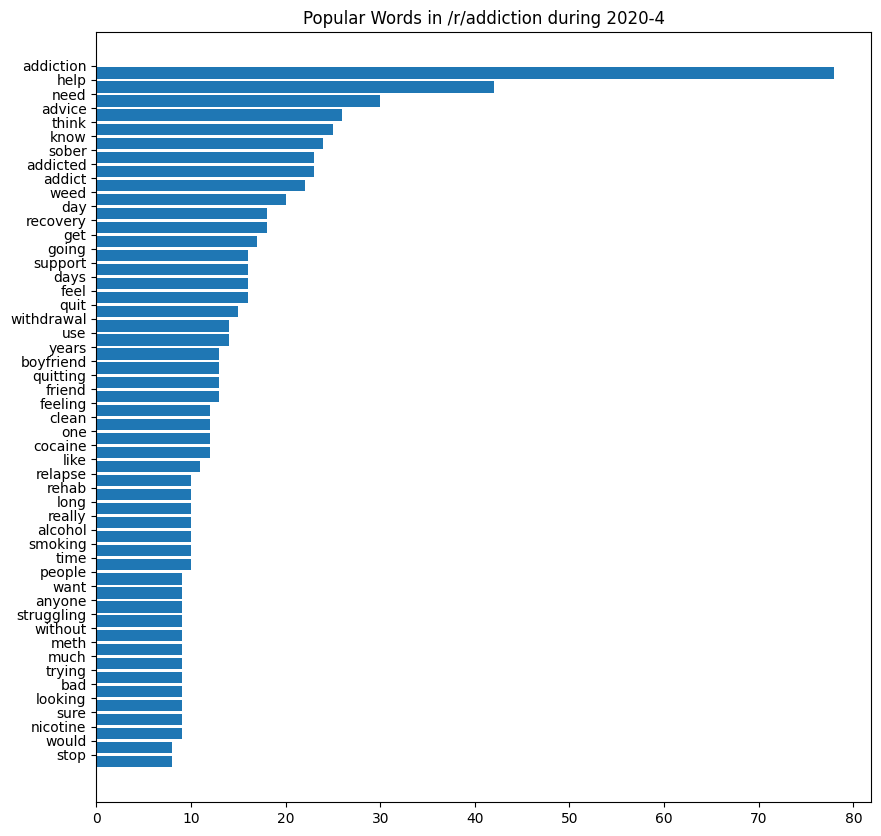

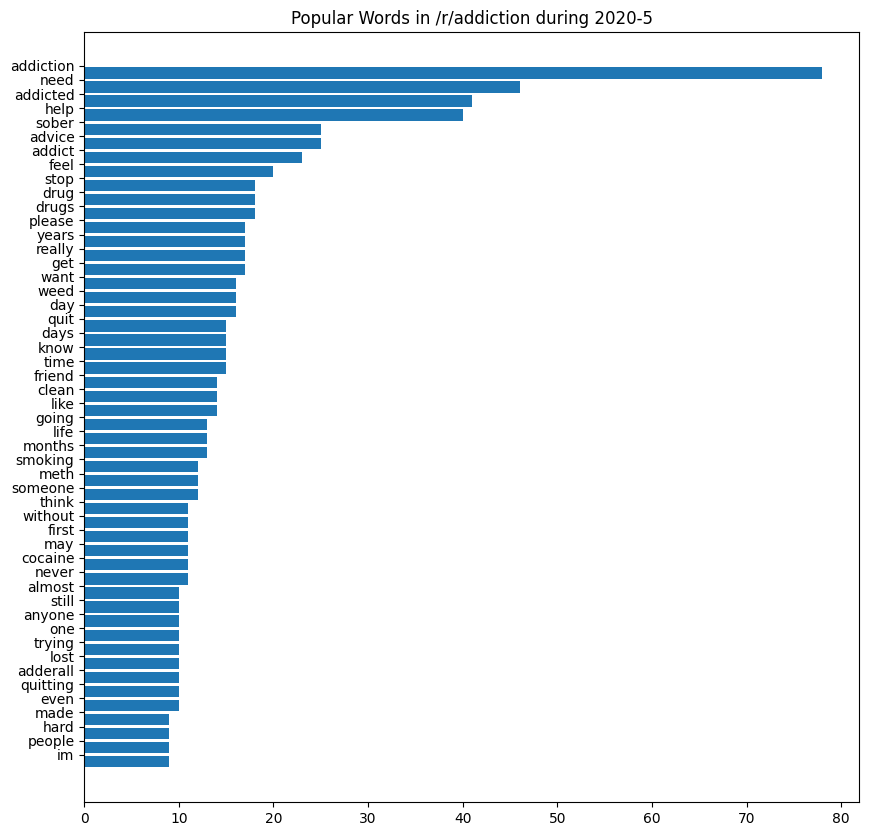

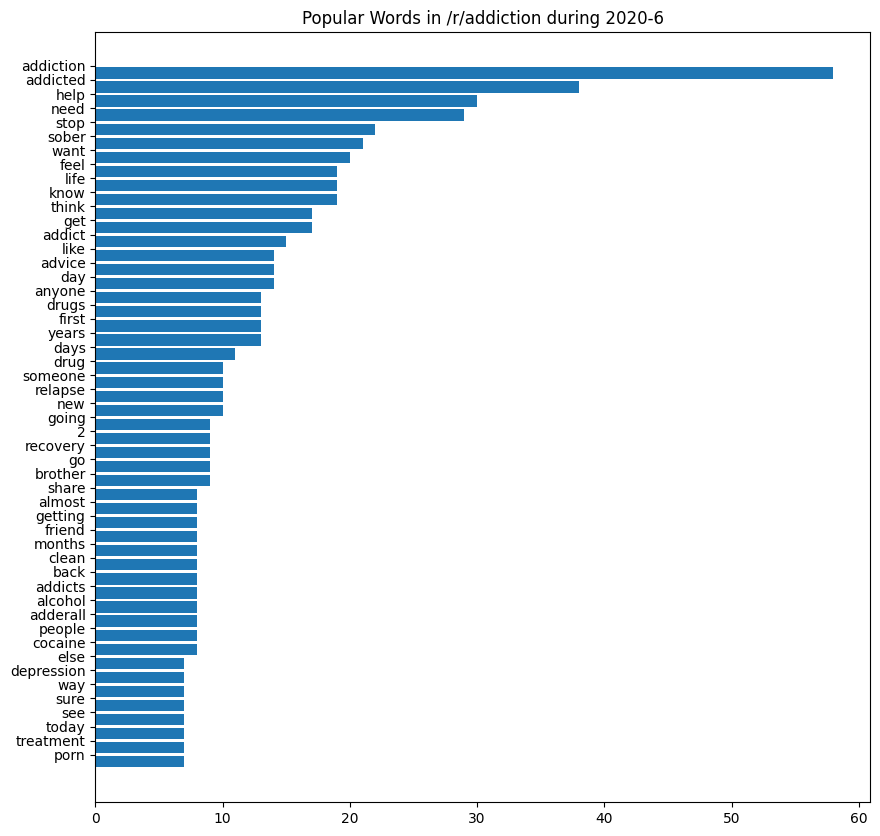

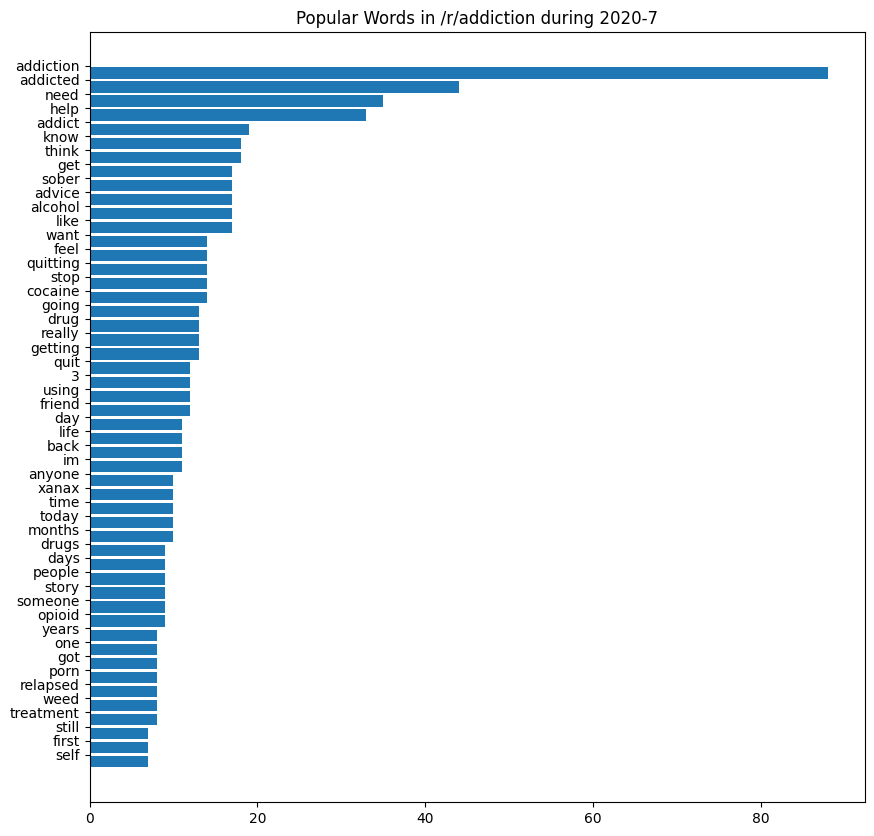

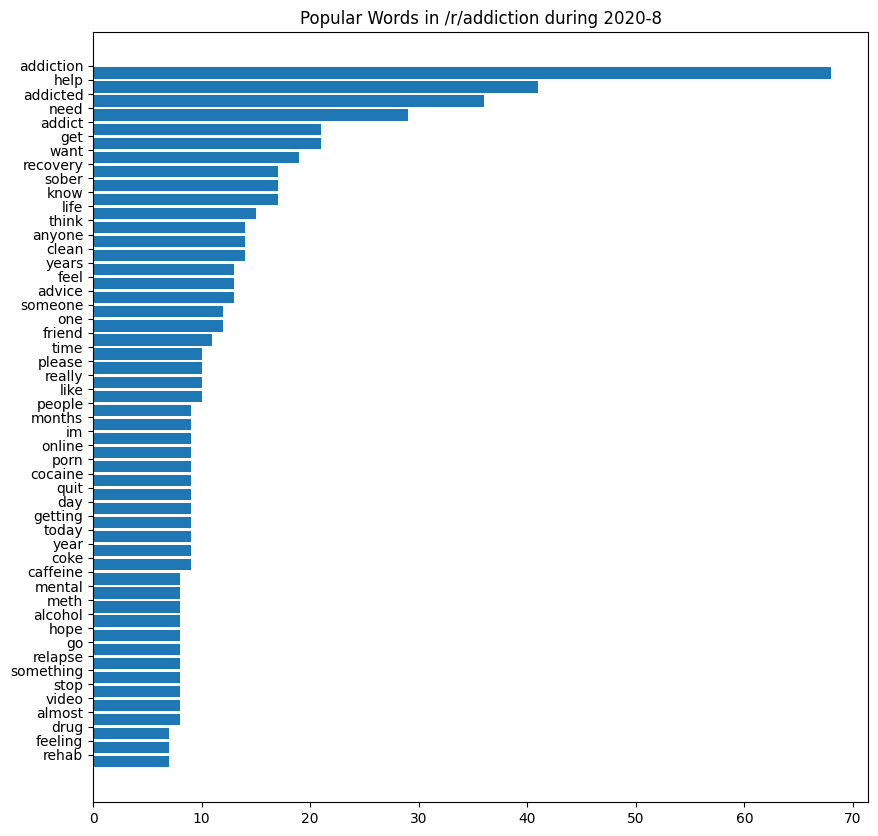

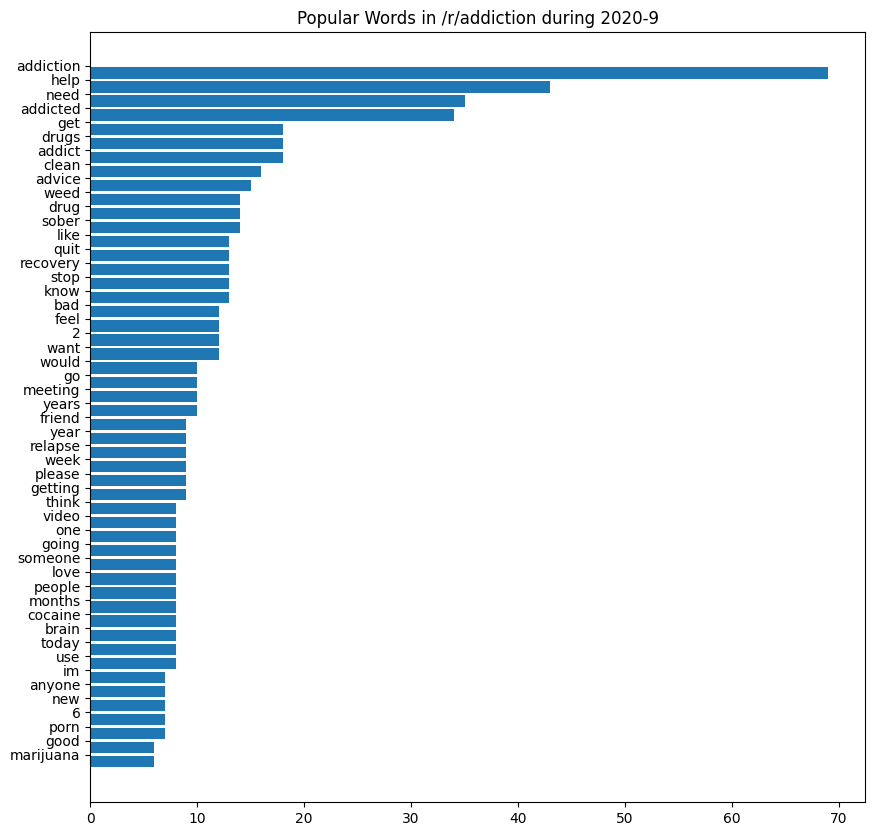

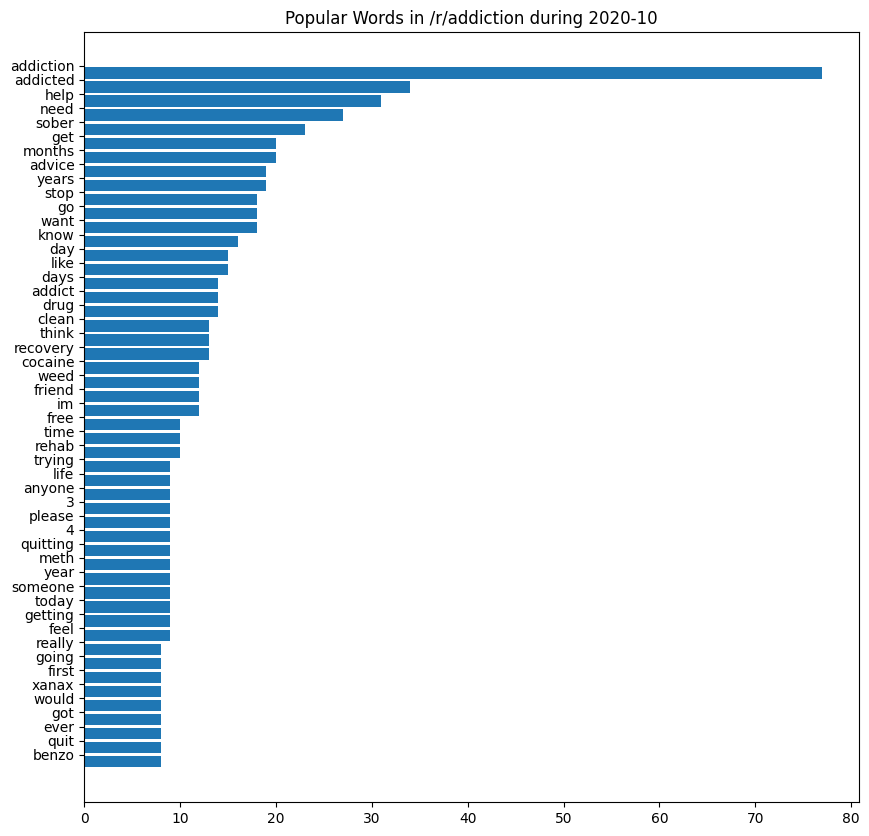

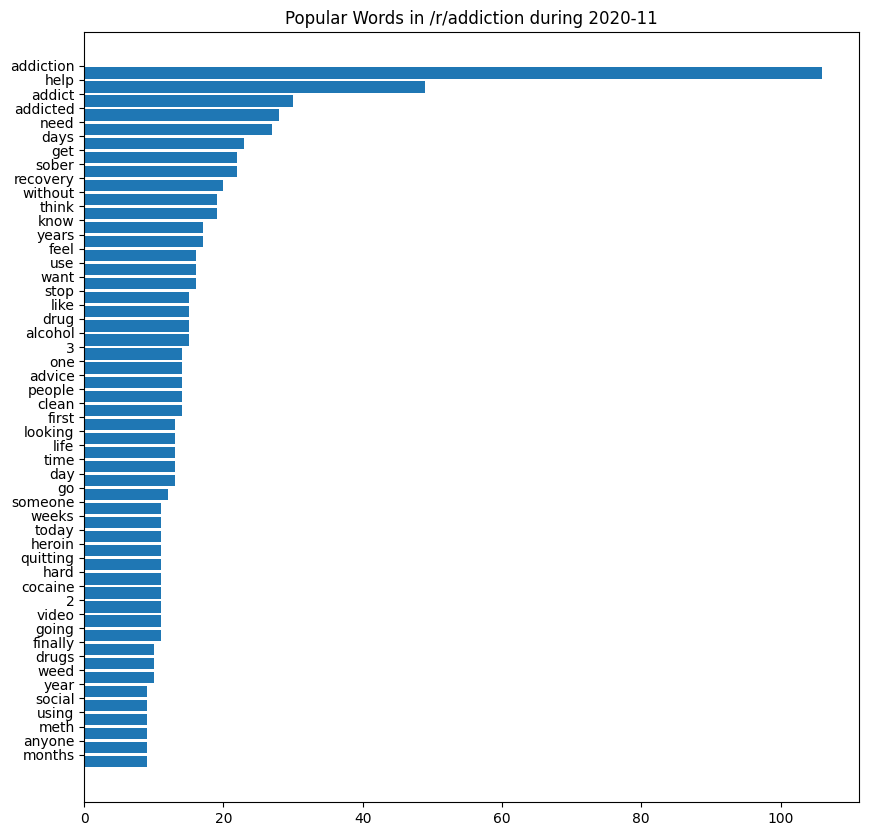

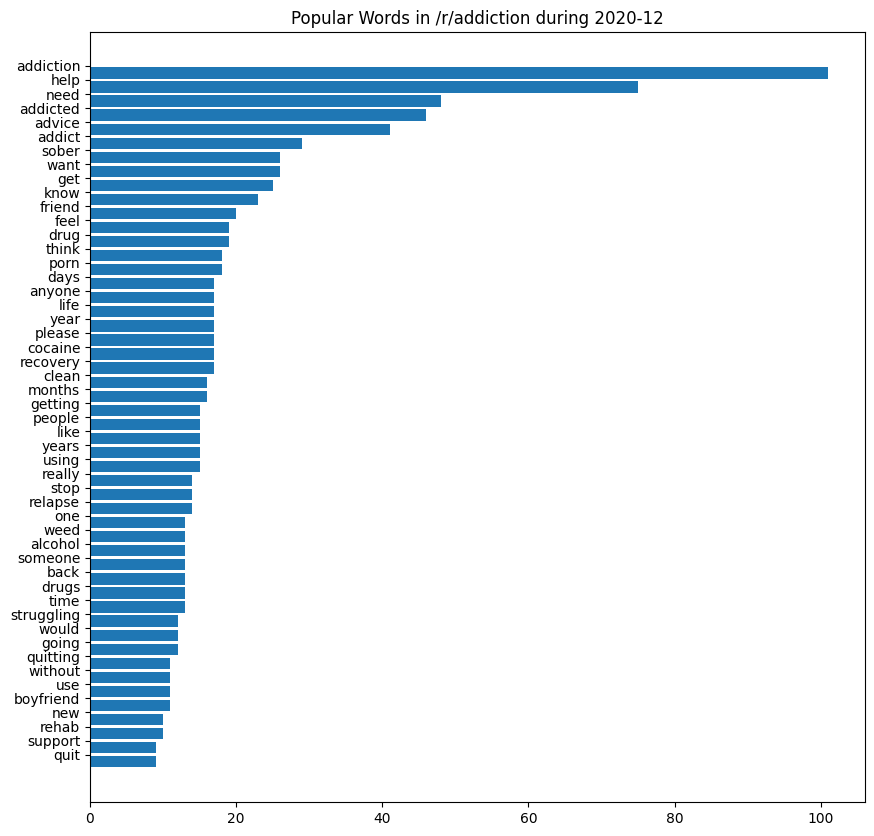

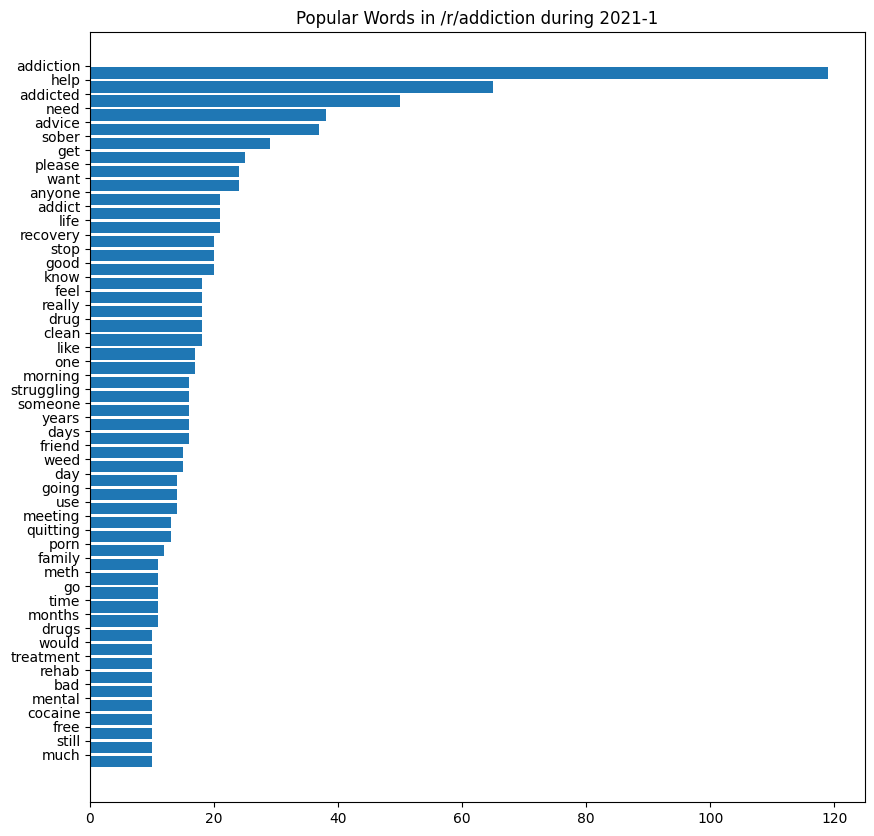

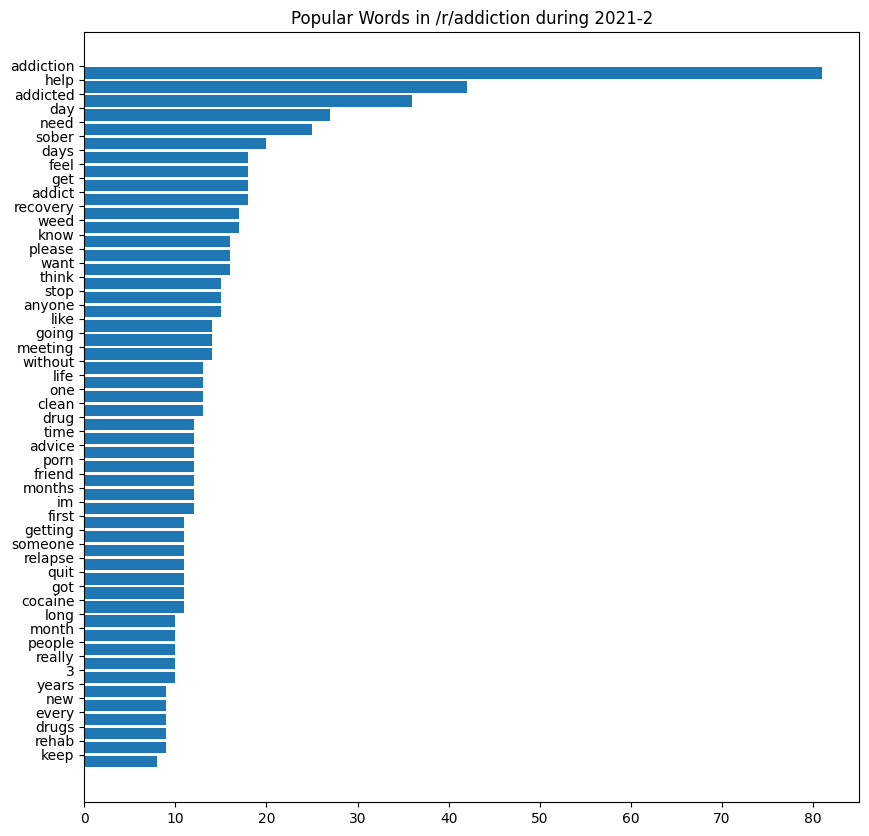

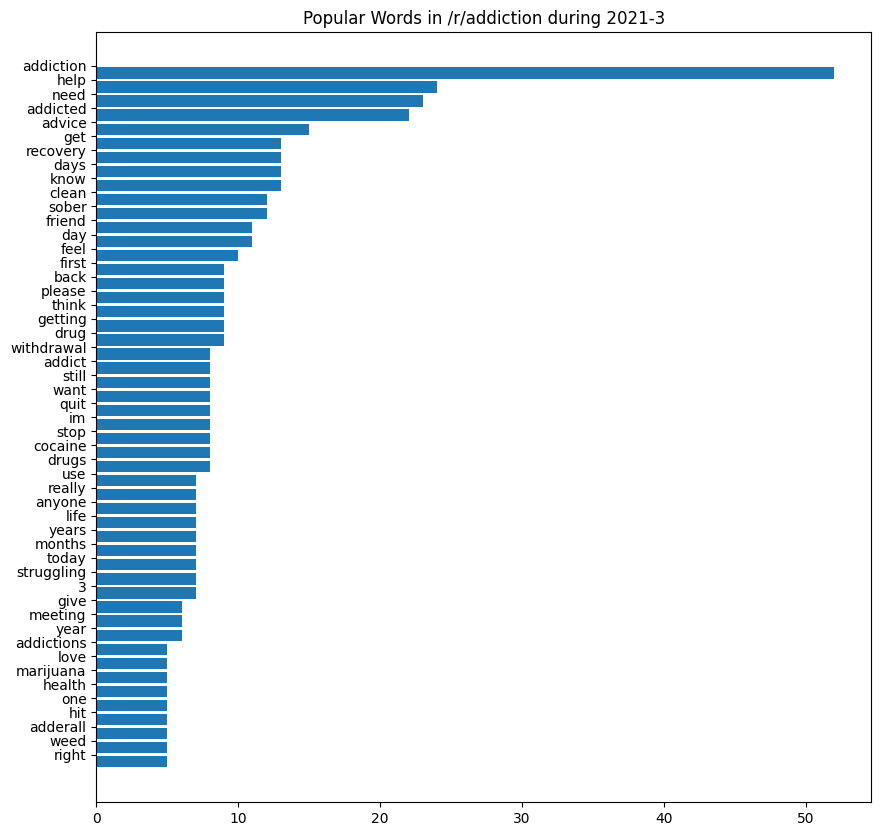

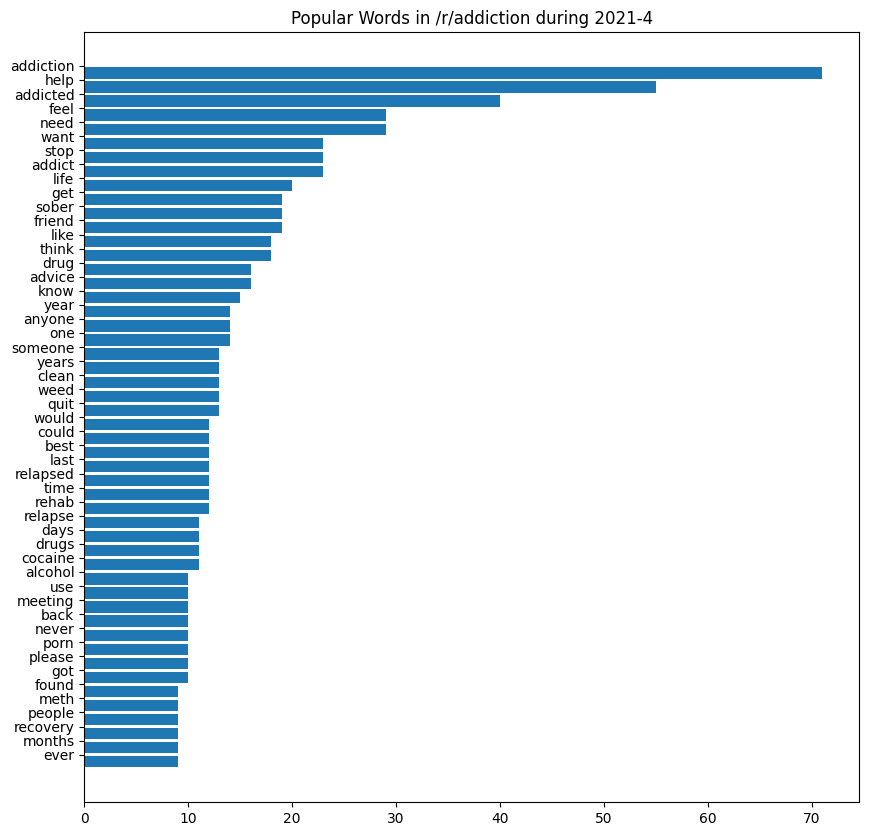

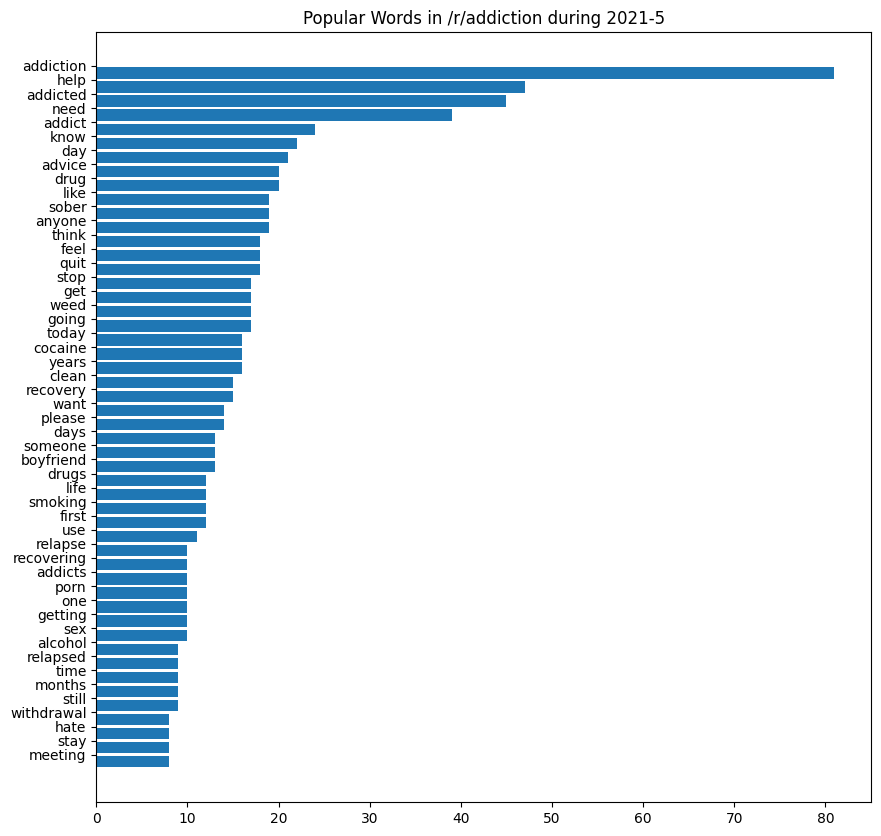

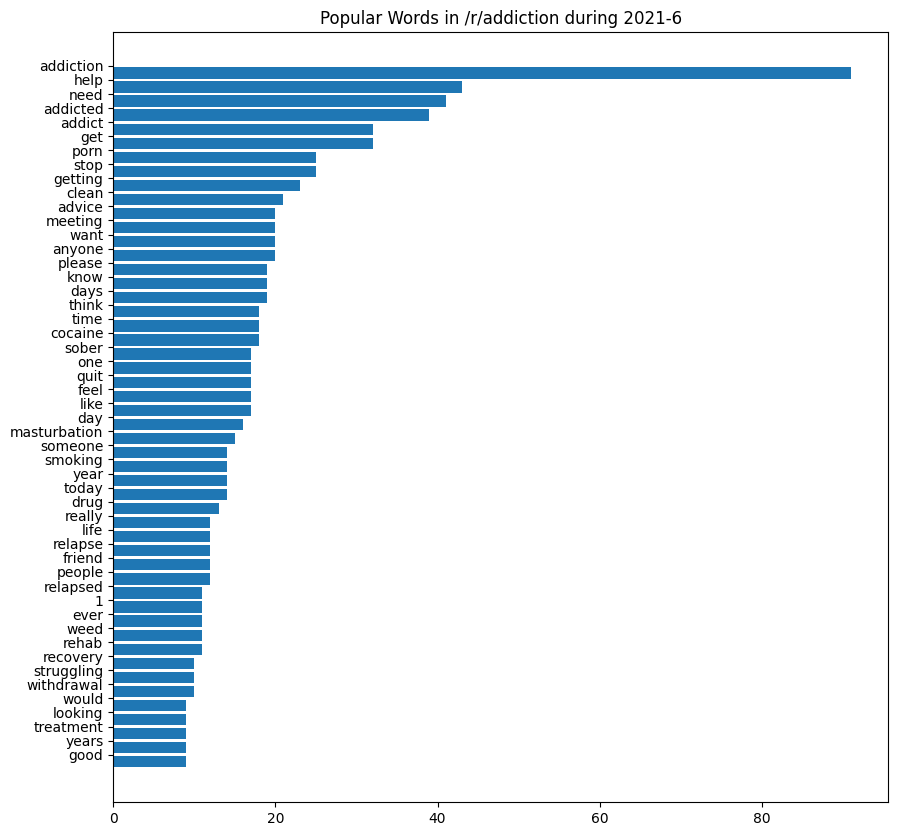

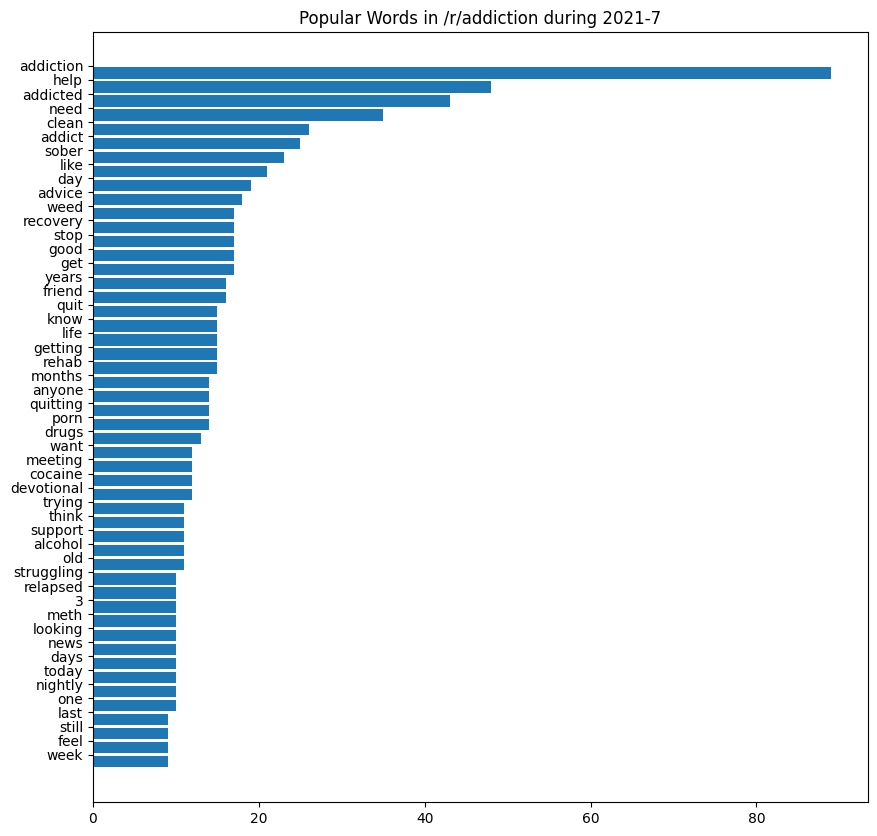

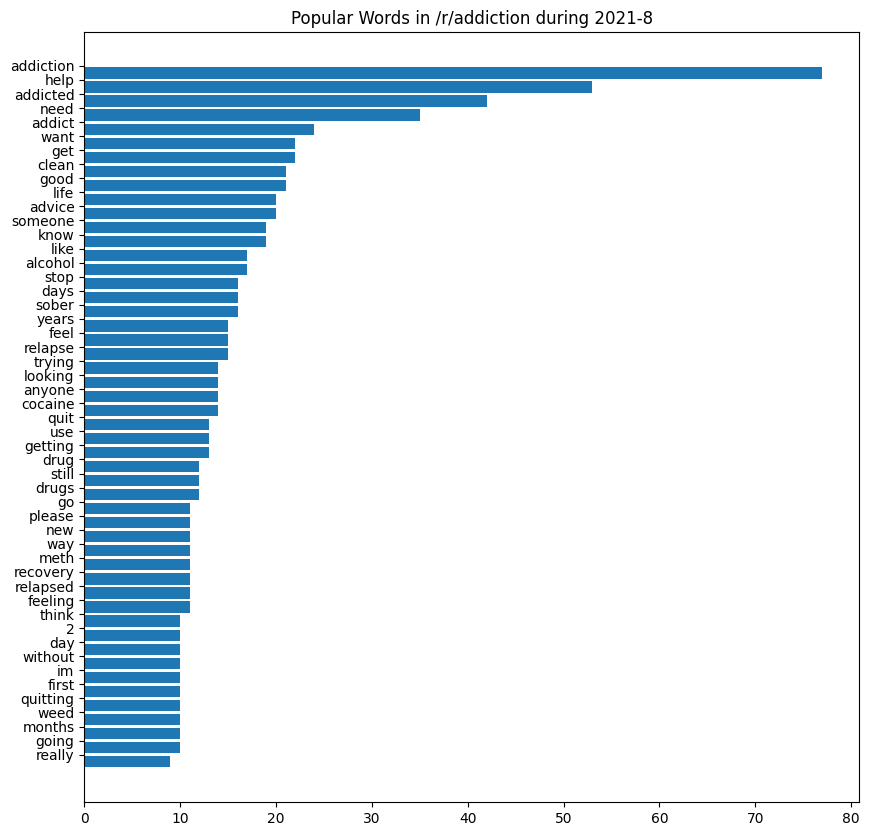

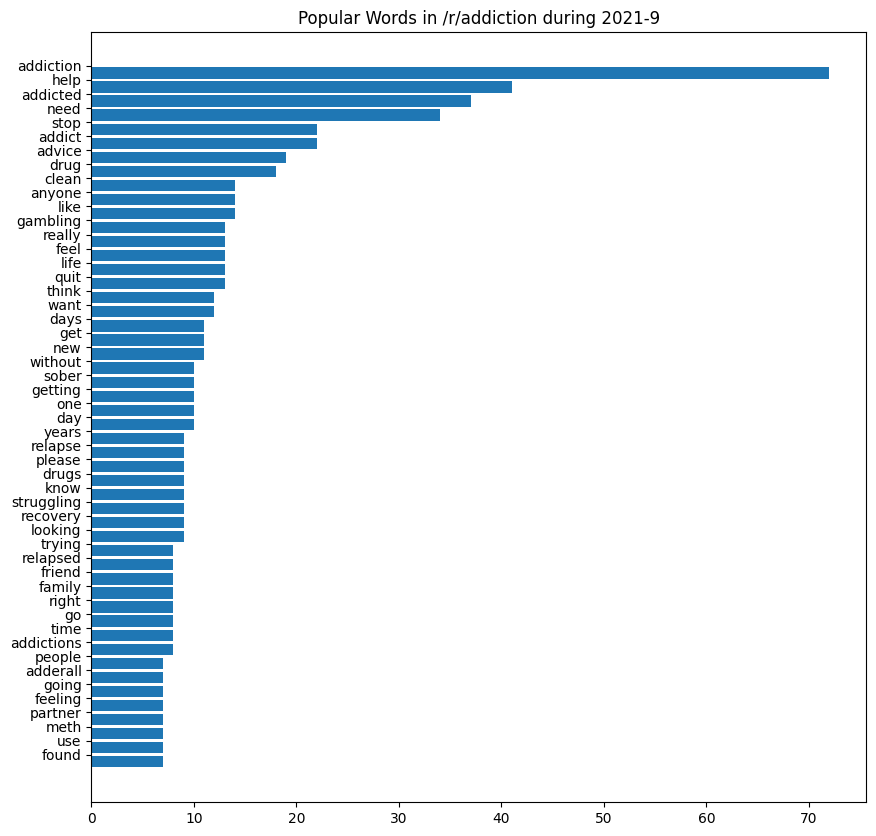

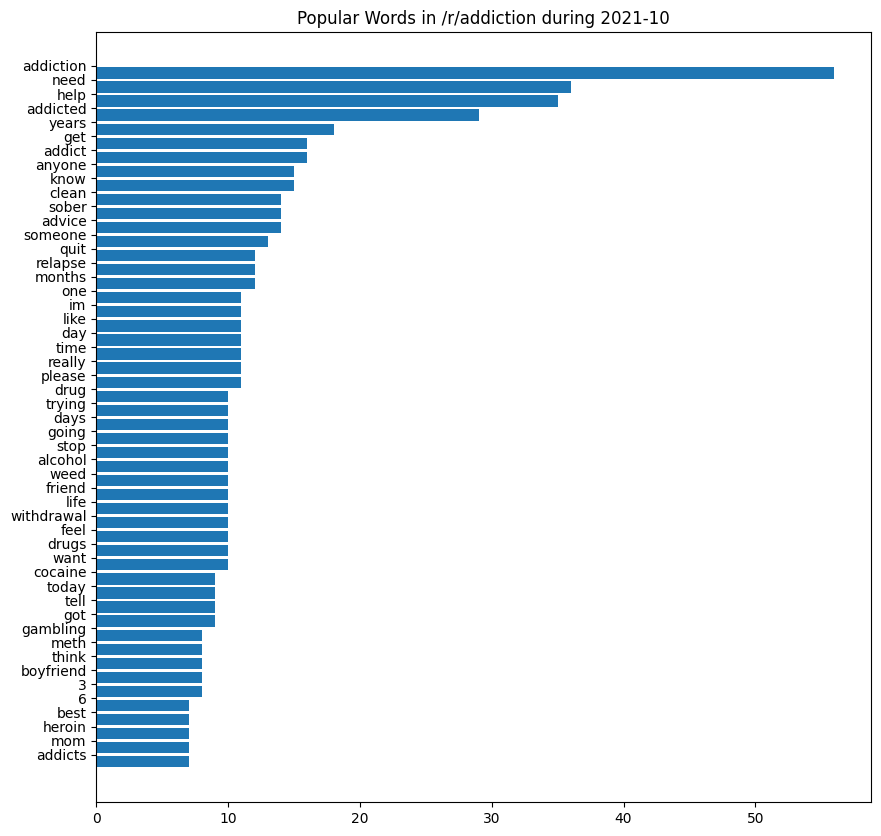

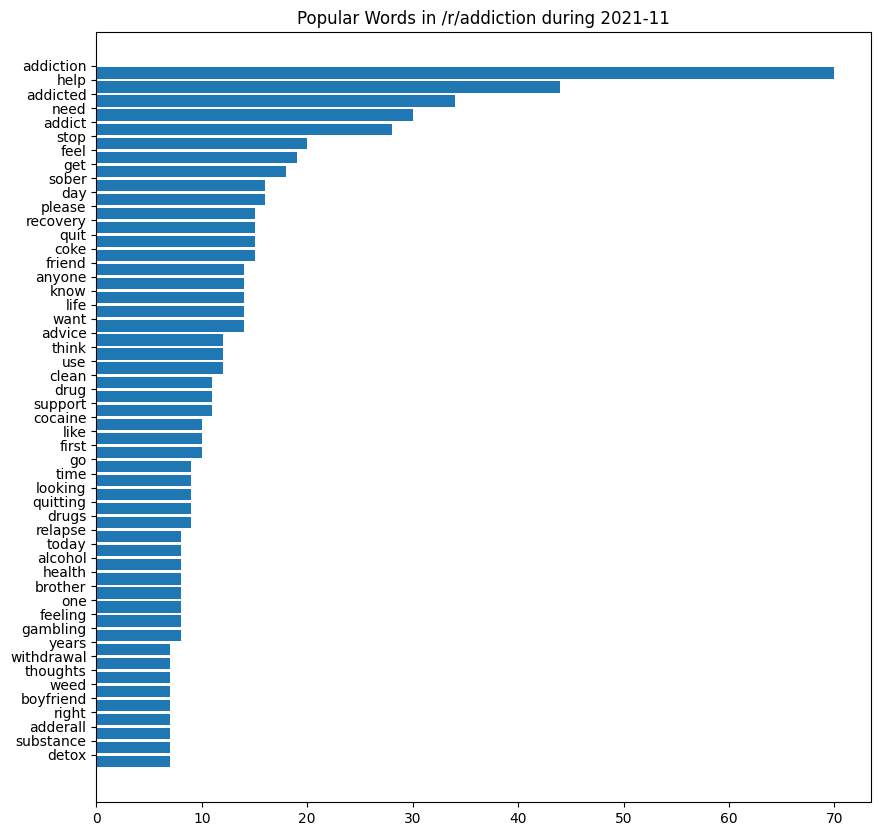

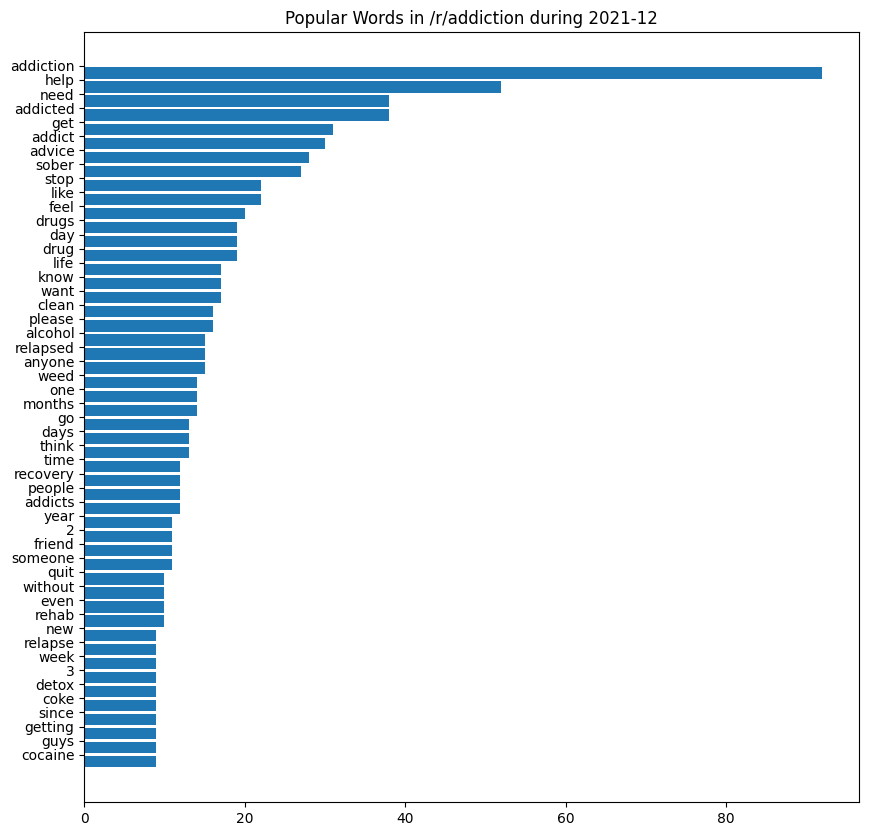

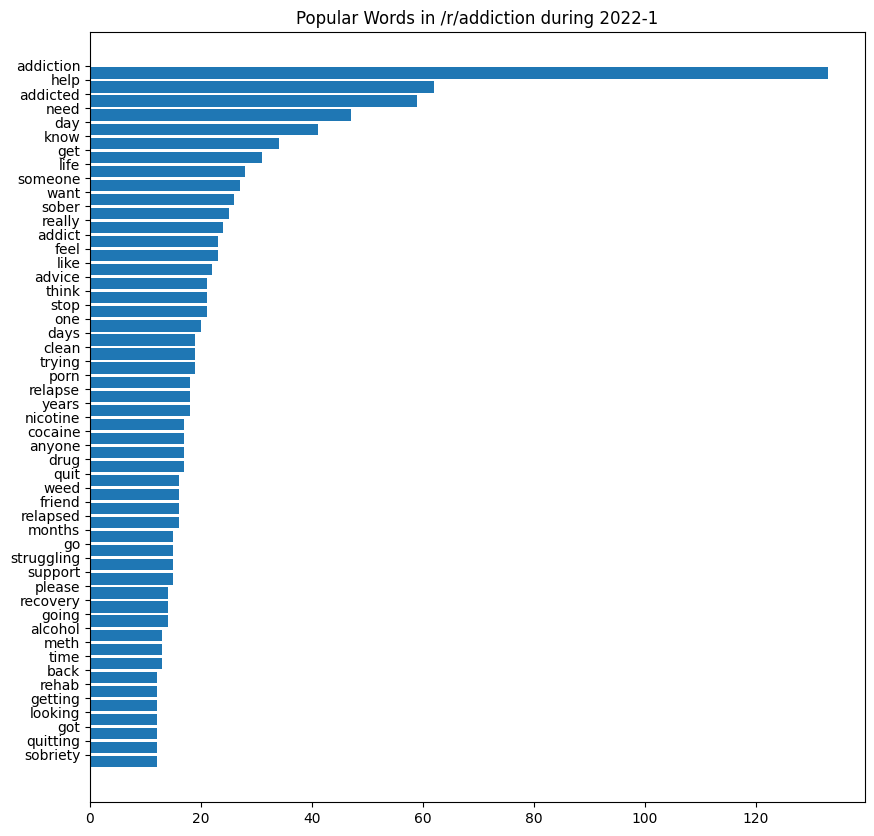

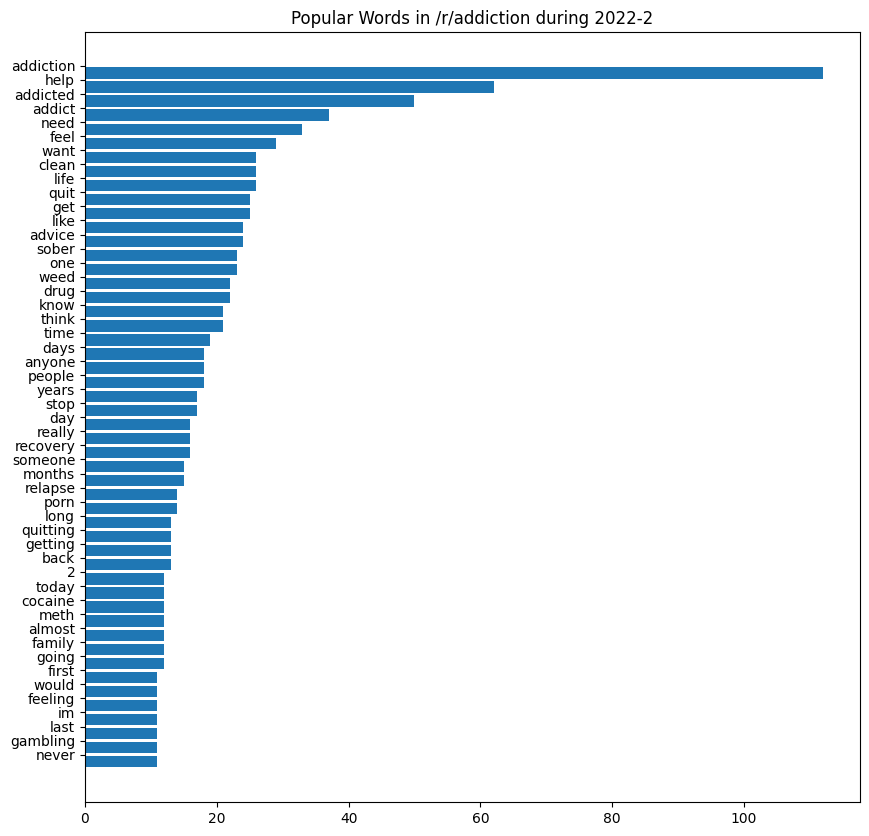

In [8]:
custom_stopwords = ["deleted", "removed"]
stopwords_set = set(stopwords.words('english') + custom_stopwords)

def wordBarGraph(df,column,title):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords_set and w.isalnum()]
    plt.barh(range(50), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:50])])
    plt.yticks([x + 0.5 for x in range(50)], reversed(popular_words_nonstop[0:50]))
    plt.title(title)
    plt.show()
    
    
for subreddit in ["addiction"]: 
    for date in iter_months(start_year, start_month, end_year, end_month): 
        df = pd.read_csv(f'data/{subreddit}/{subreddit}_{date["year"]}-{date["month"]}.csv')
        plt.figure(figsize=(10,10))
        wordBarGraph(df,'Title',f"Popular Words in /r/{subreddit} during {date['year']}-{date['month']}")
    
    


In [49]:
freq = dict()

for subreddit in subreddits:
    print(f"{subreddit}:")
    for date in iter_months(start_year, start_month, end_year, end_month): 
        submission_list = list() #initialize empty list
        df = pd.read_csv(f'data/{subreddit}/{subreddit}_{date["year"]}-{date["month"]}.csv')
        for index, row in df.iterrows():
            submission_list.append(str(row["Title"]))
        for title in submission_list:
            for word in nltk.word_tokenize(title):
                if word.isalnum() and word not in stopwords:
                    if word in freq.keys():
                        freq[word] = freq[word] + 1
                    else: 
                        freq[word] = 1
        c = Counter(freq)
        print(c.most_common(10))


[nltk_data] Downloading package stopwords to /home/zeyad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/zeyad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


addiction:
[('I', 226), ('addiction', 64), ('help', 31), ('My', 29), ('addicted', 26), ('need', 26), ('How', 23), ('What', 21), ('get', 21), ('know', 19)]
[('I', 430), ('addiction', 126), ('help', 65), ('addicted', 46), ('My', 45), ('sober', 44), ('How', 43), ('What', 41), ('need', 40), ('addict', 36)]
[('I', 644), ('addiction', 190), ('help', 102), ('My', 84), ('addicted', 73), ('need', 70), ('Addiction', 65), ('addict', 62), ('How', 61), ('sober', 58)]
[('I', 861), ('addiction', 259), ('help', 134), ('addicted', 117), ('My', 109), ('How', 89), ('addict', 86), ('need', 84), ('Addiction', 81), ('sober', 73)]
[('I', 1068), ('addiction', 326), ('help', 182), ('addicted', 143), ('My', 126), ('need', 117), ('How', 113), ('addict', 97), ('Addiction', 96), ('sober', 88)]
[('I', 1282), ('addiction', 387), ('help', 211), ('addicted', 171), ('How', 147), ('My', 145), ('need', 137), ('addict', 117), ('Addiction', 112), ('get', 109)]
[('I', 1561), ('addiction', 477), ('help', 251), ('addicted', 1

KeyboardInterrupt: 